# Minimal code to reproduce the anomalies of the algorithm

[![Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/DentanJeremie/demosaicing-detection/blob/main/doc/minimal_reproducing_code.ipynb)

**Author:** Jérémie Dentan

The goal of this repository is to provide a minimal piece of code to reproduce some limitations of the Demosaicing Detection algorithms proposed by Quentin Bammey, Rafael Grompone von Gioi and Jean-Michel Morel in the article "Demosaicing to Detect Demosaicing and Image Forgeries".

More precisely, there are two limitations that we observed and that we would like to highlight here:
1. The dataset of images `no_noise_dataset` that is used in the paper and that is supposed to be free of any demosaicing traces, is not. We prove our point by showing that, for a given image, the method detects a demosaicing with the bilinear algorithm and pattern `RGGB` with a very significant NFA of 1e-160.
2. After a JPEG compression, even of good quality (95 or 90), some algorithms are *intrisically* better at approximating the original colours of an image, which leads to their false detection. More specifically, let's we take an image and perform a first mosaicing-demosaicing step with a given pattern `P` and algorithm `A` that we now want to detect *a posteriori*. If we perform a JPEG compression between the first demosaicing and the detection of the algorithm, then some algorithms are better than other to approximate the original image, and will be detected insted of algorithm `A` with high NFA value. 

**Explainations:**
* The fact that we obtain false detection with very high NFA values do not contradict the *a-contrario* theory nor the NFA calculations of the authors.
* Indeed, the consequences of those limitations is that **given the intrisic gap of performances of some algorithm, it is false to consider a uniform distribution on the algorithms in the a-contrario hypothesis.** Indeed, the better-performing algorithm instrisically have a higher probability of correctly approximating the image, so a NFA computed with uniform distribution for the a-contrario model leads to some false detections, even with a really small NFA detection threshold.

**Few implementation details:**
* The three demosaicing we tested here are the one implemented in the Python Library `colour-demosaicing`: `bilinear` (simple bilinear interpolation of the colours), `malvar` (paper "High-quality linear interpolation for demosaicing of bayer-patterned colour images", Malvar et al, 2004), and `menon` (paper "Demosaicing with directional filtering and a posteriori decision", Menon et al, 2007). Admittedly, those are ancient, old demosaicing algorithms. However, if we can observe those limitations with those simple algorithms, there is no reason why they would bo fully absent with in a collection of more recent algorithms.
* The four patters we test are all Bayer CFA patterns: `RGGB`, `BGGR`, `GRBG`, `GBRG`
* When there is a tie for the approximation of a 2x2 block, the tie is breaken using a random choice among all configurations that minimize the mean of the absolute L1 reconstruction error.

## Set up

You should run this notebook with `Python 3.9`. Moreover, this notebook is supposed to work with the code of repository [https://github.com/DentanJeremie/demosaicing-detection](https://github.com/DentanJeremie/demosaicing-detection), having the dependencies in `requirements.txt` installed and with your PYTHONPATH set to the root of the repository.

The following lines should do this for you. The first outputed line after the verbose should be a path to the root of the repository:
- If you are using this notebook directly from the repository, please set `CLONE_REPO=False` 
- If you are using this notebook as a standalone, please set `CLONE_REPO=True`

In [1]:
CLONE_REPO = True

In [2]:
from pathlib import Path
import os

REPO_NAME = 'demosaicing-detection'
REQUIREMENTS = 'requirements.txt'

# If all of this already have been done
if Path(os.getcwd()).name == REPO_NAME and Path('requirements.txt').exists():
    print('We are already at the root of the repo!')
    CLONE_REPO = False

# If we need to clone the repo but it's already here
if CLONE_REPO and Path(REPO_NAME).exists():
    print("The repository already exists!")
    CLONE_REPO = False
    os.chdir(REPO_NAME)
    assert Path(REQUIREMENTS).exists(), "There exists an incomplete version of the repository, please delete it and try again"

# If we need to clone the repo and it isn't here
os.environ['CLONE_REPO'] = str(CLONE_REPO)
!if [ "$CLONE_REPO" = "True" ]; then git clone https://github.com/DentanJeremie/demosaicing-detection; fi
if CLONE_REPO:
    os.chdir(REPO_NAME)
    CLONE_REPO = False

# If the notebook is already in the repo, we simply need to move to the root
if not CLONE_REPO:
    while not (Path('requirements.txt')).exists():
        os.chdir('..')

# Installing dependencies, setting PYTHONPATH
print('This should be the root of the repo:')
!pwd
%pip install -r requirements.txt --quiet
!export PYTHONPATH=$(pwd)
print("All dependencies have been installed, you're ready to go!")

This should be the root of the repo:
/Users/jeremie/Documents/02-Scolarité/01-MVA/03-Cours_S2/03-DetectionTheory/demosaicing-detection
Note: you may need to restart the kernel to use updated packages.
All dependencies have been installed, you're ready to go!


In [3]:
from matplotlib import pyplot as plt
import numpy as np
from scipy.stats import binom

from src.utils.constants import *
from src.utils.datasets import no_noise_dataset
from src.forgery_tools.forge import forge
from src.forgery_tools.vote import get_block_votes, get_block_votes_on_algo
from src.forgery_tools.detect import detect_config

%matplotlib inline
np.random.seed(42)

      393946ms INFO  [datasets.py] Initiating a dataset over the no_noise_images dataset
      393947ms INFO  [datasets.py] More info at http://mcolom.info/pages/no_noise_images/
      393966ms INFO  [datasets.py] no_noise_images found at /data/no_noise_images


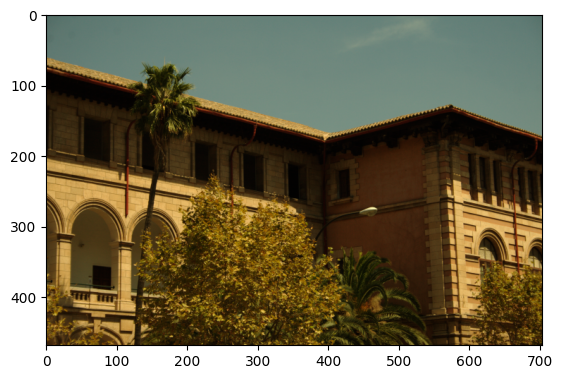

In [4]:
# The image we'll use, taken from http://mcolom.info/pages/no_noise_images/

image = no_noise_dataset[0]
plt.imshow(image)
plt.show()
plt.close()

## First limitation: the dataset is not free of any demosaicing traces

As explained below, we will first provide a piece of code to show that the images of the `no_noise_dataset` are not free of any demosaicing traces, contrary to what was said in the paper.

To do so, we will use the method of the paper: divide the image in 2x2 blocks, and make then vote for the tuple (algo, pattern) that best reconstructs this 2x2 block after a mosaicing-demosaicing step.

In [5]:
# Fixing random generator for reproducibility
np.random.seed(42)

**1.** First, we see that we detect the configuration (`bilinear`, `RGGB`) with NFA=1e-160

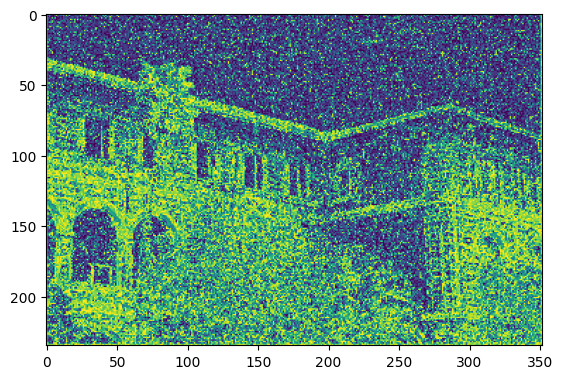

Votes for each of the 12 configurations (algo, pattern):
0:9121
1:8981
2:9064
3:8997
4:4390
5:4339
6:4248
7:4390
8:7404
9:7194
10:7339
11:7253
Num votes = 82720
Detection: 0 with -log(NFA)=156.9584060920554
Double check: 12 * binom.sf(9121, 82720, 1/12) = 1.1005097839377306e-157


In [6]:
votes = get_block_votes(image) # The votes for the configuration (algo, pattern) as int between 0 and 11
plt.imshow(votes)
plt.show()
plt.close()
print('Votes for each of the 12 configurations (algo, pattern):')
votes_count = 0
for value, count in zip(*np.unique(votes, return_counts=True)):
    print(f'{value}:{count}')
    votes_count += count
print(f'Num votes = {votes_count}')
config, nfa = detect_config(votes, len(ALGO_PATTERN_CONFIG)) # Detection of the algorithm: -1 for no detection
print(f'Detection: {config} with -log(NFA)={nfa}')
print(f'Double check: 12 * binom.sf(9121, 82720, 1/12) = {12 * binom.sf(9121, 82720, 1/12)}')

**2.** Then, we see that we detect the algorithm `bilinear` with NFA=0

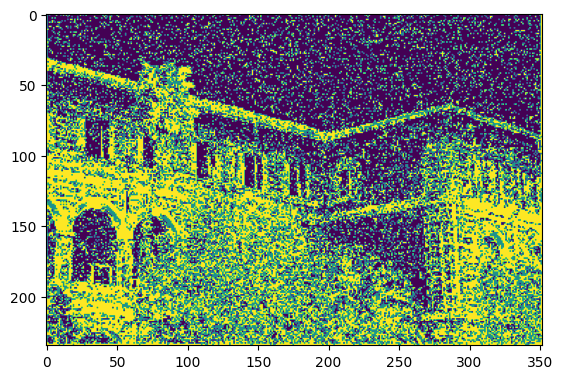

Votes for each of the 3 configurations of algorithm:
0:36163
1:17367
2:29190
Detection: 0 with -log(NFA)=inf
Double check: 3 * binom.sf(36163, 82720, 1/3) = 0.0


In [7]:
# Detecting the algorithm
votes_algo = get_block_votes_on_algo(votes) # The vote for the best algo, as int between 0 and 2
plt.imshow(votes_algo)
plt.show()
plt.close()
print('Votes for each of the 3 configurations of algorithm:')
votes_count = 0
for value, count in zip(*np.unique(votes_algo, return_counts=True)):
    print(f'{value}:{count}')
    votes_count += 1

config, nfa = detect_config(votes_algo, len(DEMOSAICING_ALGOS)) # Detection of the algorithm: -1 for no detection
print(f'Detection: {config} with -log(NFA)={nfa}')
print(f'Double check: 3 * binom.sf(36163, 82720, 1/3) = {3 * binom.sf(36163, 82720, 1/3)}')

## Second limitation: some algorithms are intrisically better than others

Now, we will show that some demosaicing algorithms are intrisically better than other, which lead to their false detection even with very low NFA threshold.

More specifically, we will:
* Apply a first step of mosaicing-demosaicing with the `bilinear` algorithm and pattern `RGGB`
* Apply a JPEG compression of quality 95 on the obtained image (those two steps are done by the function `forge`)
* Get the votes of the 2x2 blocks, and see that we detect the `malvar` algorithm with pattern `RGGB`

This shows that the `malvar` algorithms is instrisically better than `bilinear` at reconstructing the colors of an image after a JPEG compression, which makes the uniform assumption of the a-contrario model biased, leading to false detection of the `malvar` algorithm.

In [8]:
np.random.seed(42)

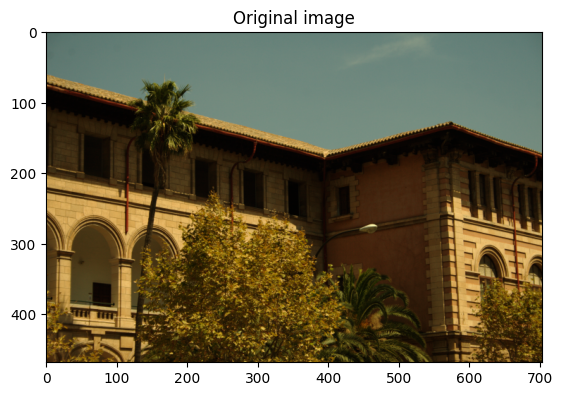

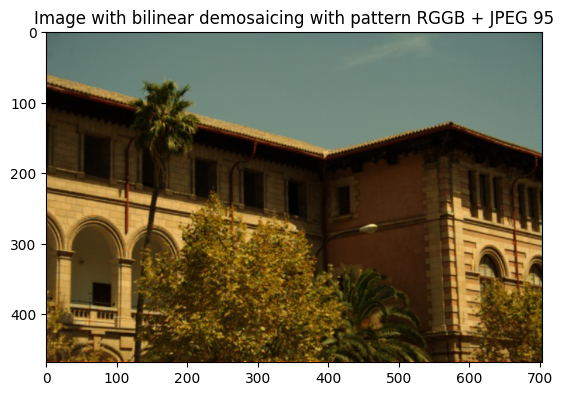

In [9]:
image = no_noise_dataset[0]
demosaiced_and_compressed = forge(
    image,
    demosaicing_algo='bilinear',
    pattern='RGGB',
    jpeg_compression=95,
)

plt.imshow(image)
plt.title('Original image')
plt.show()
plt.close()
plt.imshow(demosaiced_and_compressed)
plt.title('Image with bilinear demosaicing with pattern RGGB + JPEG 95')
plt.show()
plt.close()

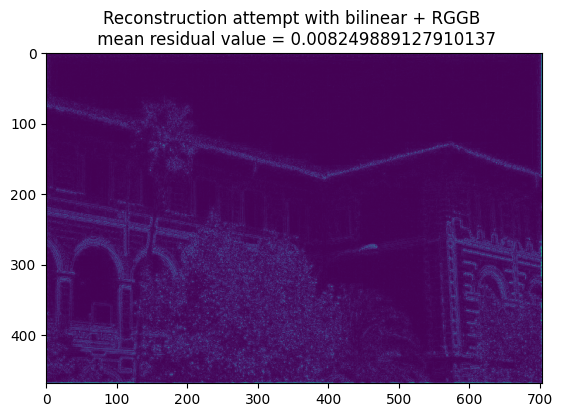

In [10]:
reconstruction_same_algo = forge(
    image=demosaiced_and_compressed,
    demosaicing_algo='bilinear',
    pattern='RGGB',
)
residual = np.abs(demosaiced_and_compressed - reconstruction_same_algo)
residual_one_channel = np.mean(residual, axis=2)

plt.imshow(residual_one_channel)
plt.title(f'Reconstruction attempt with bilinear + RGGB \n mean residual value = {np.mean(residual_one_channel)}')
plt.show()
plt.close()

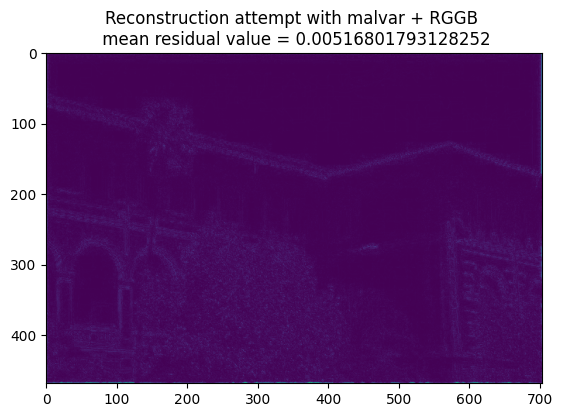

In [11]:
reconstruction_other_algo = forge(
    image=demosaiced_and_compressed,
    demosaicing_algo='malvar',
    pattern='RGGB',
)
residual = np.abs(demosaiced_and_compressed - reconstruction_other_algo)
residual_one_channel = np.mean(residual, axis=2)

plt.imshow(residual_one_channel)
plt.title(f'Reconstruction attempt with malvar + RGGB \n mean residual value = {np.mean(residual_one_channel)}')
plt.show()
plt.close()

**We observe a difference in the mean $L_\infty$ reconstruction error (0.0052 vs 0.0082). This will lead to the detection of the wrong algorithm in the a-contrario setting.**

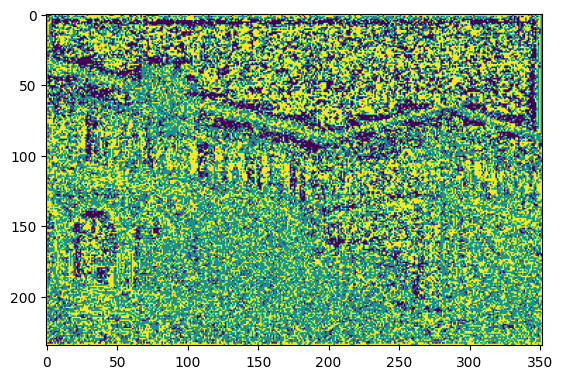

Votes for each of the 3 configurations of algorithm:
0:17191
1:33727
2:31802
Detection: 1 with -log(NFA)=inf
Double check: 3 * binom.sf(33727, 82720, 1/3) = 0.0


In [12]:
# Detecting the algorithm
votes = get_block_votes(demosaiced_and_compressed)
votes_algo = get_block_votes_on_algo(votes) # The vote for the best algo, as int between 0 and 2
plt.imshow(votes_algo)
plt.show()
plt.close()
print('Votes for each of the 3 configurations of algorithm:')
votes_count = 0
for value, count in zip(*np.unique(votes_algo, return_counts=True)):
    print(f'{value}:{count}')
    votes_count += 1

config, nfa = detect_config(votes_algo, len(DEMOSAICING_ALGOS)) # Detection of the algorithm: -1 for no detection
print(f'Detection: {config} with -log(NFA)={nfa}')
print(f'Double check: 3 * binom.sf(33727, 82720, 1/3) = {3 * binom.sf(33727, 82720, 1/3)}')